# BridgeRank Implementation
BridgeRank: A novel fast centrality measure based on local structure of the network
Link: https://www.sciencedirect.com/science/article/pii/S0378437117313419 <br>
Note: The following implementation works for undirected, unweighted graphs

In [1]:
import community.community_louvain as community_louvain
import networkx as nx

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Graphs downloaded from: https://github.com/cds-group/GraphDatasets/blob/master/GraphData/Synthetic/LFR.zip

In [5]:
# Class that holds a graph and its information
class GraphAnalysis:
    # Constructor
    def __init__(self, path, custom_edges=None):
        #path = "LFR/nets01/network4.dat"
        self.edges = None
        if custom_edges is None:
            with open(path) as f:
                lines = f.readlines()
            # Parse data from file
            self.edges = [line.strip().split(' ') for line in lines] # Data is in EdgeList format
        else:
            self.edges = custom_edges
        # Initialize graph
        self.G = nx.Graph()
        self.G.add_edges_from(self.edges)
        # Save graph layout
        self.pos = nx.spring_layout(self.G)
        # Define variable to be used by bridgerank
        self.partition = None # dictionary that assigns each node to a cluster/ community
        self.inv_partition = None # dictionary that has a list of all nodes stored for each community
        self.core_nodes = None # list of core nodes from each community
        
    # Plotting a graph, highlight nodes argument make the selected list of nodes red
    def visualize_graph(self, highlight_nodes=None): #highlight_nodes is a list
        nx.draw_networkx(self.G, pos=self.pos)
        if highlight_nodes is not None:
            nx.draw_networkx(self.G.subgraph(highlight_nodes), pos=self.pos, node_color='red') #font_size=16, node_color='blue', font_color='white')
        plt.show()
    
    # function that does community assignment
    def assign_community_label_to_nodes(self):
        self.partition = community_louvain.best_partition(self.G) # Maps: Node -> CommunityIdx
        # do inverse mapping of partition dictionary to get inv_partition
        inv_partition = {}
        for k, v in self.partition.items():
            if v in inv_partition.keys():
                inv_partition[v].append(k)
            else:
                inv_partition[v] = []
        self.inv_partition = inv_partition # Maps: CommunityIdx -> list of nodes
        return self.partition
    
    # visualize communities within a graph with different colors; again, highlight nodes makes selected nodes red
    def visualize_communities(self, highlight_nodes=None):
        if self.partition is None:
            _ = self.assign_community_label_to_nodes()
        cmap = cm.get_cmap('viridis', max(self.partition.values()) + 1)
        nx.draw_networkx_nodes(self.G, self.pos, self.partition.keys(), node_size=100,cmap=cmap, node_color=list(self.partition.values()))
        nx.draw_networkx_edges(self.G, self.pos, alpha=0.5)
        if highlight_nodes is not None:
            nx.draw_networkx(self.G.subgraph(highlight_nodes), pos=self.pos, node_color='red') #font_size=16, node_color='blue', font_color='white')
    
    # find the node that has the highest betweenness centrality within a community
    def find_top_nodes_per_community(self): # Uses local betweenness centrality to rank
        if self.inv_partition is None:
            _ = self.assign_community_label_to_nodes()
        betweenness = {}
        for community, nodes in self.inv_partition.items():
            betweenness[community] = nx.betweenness_centrality_subset(self.G, nodes, nodes, normalized=True)
        imp_nodes_per_community = {}
        for (key,val) in list(betweenness.items()):
            dict_keys = np.array(list(val.keys()))
            dict_vals = np.array(list(val.values()))
            imp_nodes_per_community[key] = dict_keys[np.argmax(dict_vals)]
        self.core_nodes = list(imp_nodes_per_community.values())
        
    # Highlight the core nodes in a community-highlighted graph
    def visualize_cores(self):
        if self.core_nodes is None:
            self.find_top_nodes_per_community()
        self.visualize_communities(highlight_nodes=self.core_nodes)
        
    # Calculate bridgeRank for all nodes
    def bridgeRank(self):
        if self.core_nodes is None:
            self.find_top_nodes_per_community()
        # For a node V
        distances = {}
        for V in self.G.nodes:
            # Find the length of shortest path to each core node and sum them up
            distances[V] = 0
            for core_node in self.core_nodes:
                distances[V] += nx.shortest_path_length(self.G, source=V, target=core_node)
        # Take reciprocal of summed distance to get bridgeRank
        bridgeRank = {node: 1/dist for node, dist in distances.items()}
        return bridgeRank
    
    # Calculate closeness_centrality for all nodes
    def closeness_centrality(self):
        cc = nx.closeness_centrality(self.G)
        return cc
    
    # Calculate betweenness_centrality for all nodes
    def betweenness_centrality(self):
        bc = nx.betweenness_centrality(self.G, normalized=True)
        return bc
    
    # Visualize the nodes based on centrality values; gradient: navy blue -> yellow
    def visualize_centrality(self, node_values):
        cmap = cm.get_cmap('viridis', 20)
        # Assuming graph nodes and and node values are in corresponding order
        nx.draw_networkx_nodes(self.G, self.pos, self.partition.keys(), node_size=100,cmap=cmap, node_color=node_values)
        nx.draw_networkx_edges(self.G, self.pos, alpha=0.5)

# Visulization for the toy graph used in BridgeRank Paper

In [144]:
# Define edges in edgelist format
custom_edges = [[1,4],[1,2],
               [2,1],[2,4],
               [3,4],
               [4,1],[4,2],[4,3],[4,16],
               [5,4],[5,6],
               [6,5],[6,4],
               [7,8],[7,10],[7,11],
               [8,7],[8,9],[8,10],
               [9,8],[9,10],
               [10,7],[10,8],[10,9],[10,11],[10,16],
               [11,7],[11,10],
               [12,13],[12,16],[12,18],
               [13, 12],[13, 14],[13, 18],
               [14,13],[14,15],[14,17],[14,18],
               [15,14],[15,17],[15,18],
               [16,4],[16,10],[16,12],[16,17],[16,18],
               [17,14],[17,15],[17,16],[17,18],
               [18,12],[18,13],[18,14],[18,15],[18,16],[18,17]
               ]

In [8]:
path = 'graph.dat' # give empty path in case of custom edges
custom_edges = None
G = GraphAnalysis(path, custom_edges)

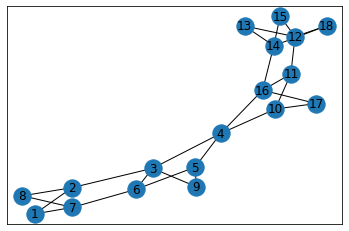

Text(0.5, 1.0, 'Visualize graph')

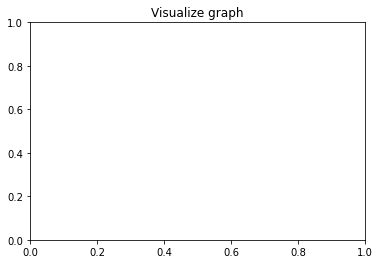

In [10]:
G.visualize_graph()
plt.title("Visualize graph")

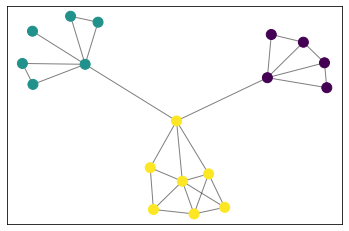

In [147]:
G.visualize_communities()
plt.title("Communities within a graph")

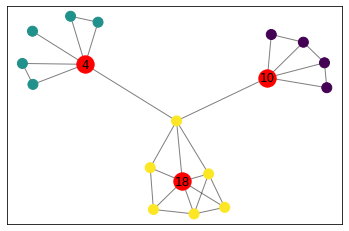

In [148]:
G.visualize_cores()
plt.title("Core nodes from each community") #The ones with highest betweenness centrality among a community

In [149]:
brc = G.bridgeRank()
brc_values = list(brc.values())

# The values match with those in the paper
brc

{1: 0.14285714285714285,
 4: 0.25,
 2: 0.14285714285714285,
 3: 0.14285714285714285,
 16: 0.3333333333333333,
 5: 0.14285714285714285,
 6: 0.14285714285714285,
 7: 0.14285714285714285,
 8: 0.14285714285714285,
 10: 0.25,
 11: 0.14285714285714285,
 9: 0.14285714285714285,
 12: 0.2,
 13: 0.14285714285714285,
 18: 0.25,
 14: 0.14285714285714285,
 15: 0.14285714285714285,
 17: 0.2}

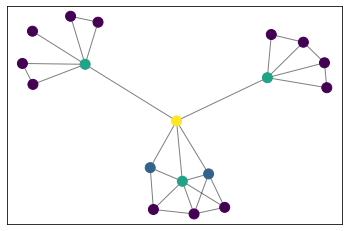

In [150]:
G.visualize_centrality(brc_values)
plt.title("BridgeRank")

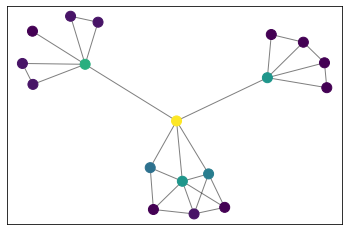

In [151]:
cc = G.closeness_centrality()
cc_vals = np.asarray(list(cc.values()))
G.visualize_centrality(cc_vals)
plt.title("Closeness Centrality")

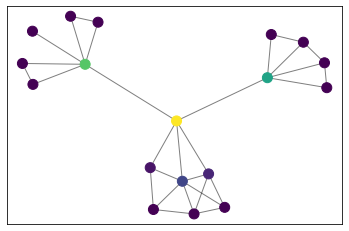

In [152]:
bc = G.betweenness_centrality()
bc_vals = np.asarray(list(bc.values()))
G.visualize_centrality(bc_vals)
plt.title("Betweenness Centrality")

# Demonstration on a real graph
Graphs downloaded from: https://github.com/cds-group/GraphDatasets/blob/master/GraphData/Synthetic/LFR.zip

In [109]:
path = "LFR/nets01/network4.dat" # Path to a downloaded graph
G1 = GraphAnalysis(path)

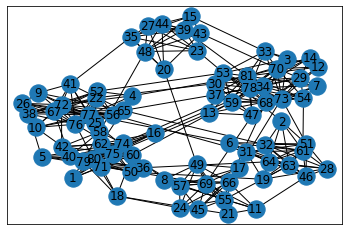

In [110]:
G1.visualize_graph()
plt.title("Visualize graph")

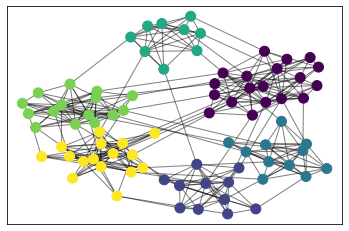

In [111]:
G1.visualize_communities()
plt.title("Communities within a graph")

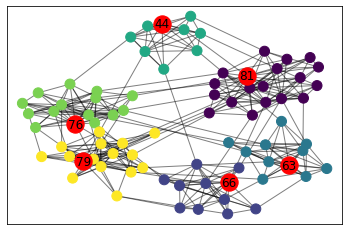

In [112]:
G1.visualize_cores()
plt.title("Core nodes from each community") #The ones with highest betweenness centrality among a community

In [113]:
brc = G1.bridgeRank()
brc_values = list(brc.values())

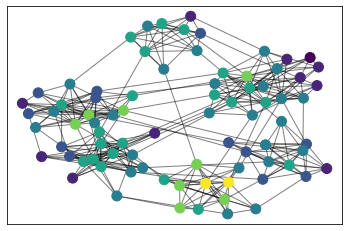

In [114]:
G1.visualize_centrality(brc_values)
plt.title("BridgeRank")

In [119]:
cc = G1.closeness_centrality()
cc_vals = np.asarray(list(cc.values()))

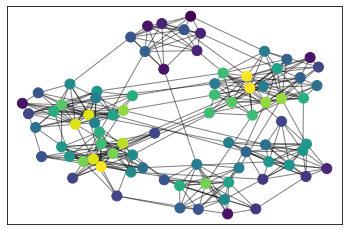

In [120]:
G1.visualize_centrality(cc_vals)
plt.title("Closeness Centrality")

In [121]:
bc = G1.betweenness_centrality()
bc_vals = np.asarray(list(bc.values()))

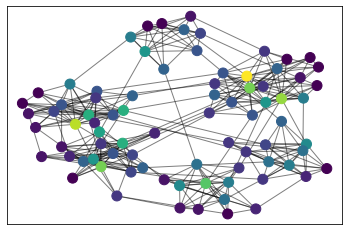

In [122]:
G1.visualize_centrality(bc_vals)
plt.title("Betweenness Centrality")